In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_video
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("All modules loaded")

All modules loaded


In [2]:
# Define paths
DATA_DIR = '/home/ryujjoo0810/jooyoung2/pcm/videos'
CSV_FILE = '/home/ryujjoo0810/jooyoung2/pcm/video_labels.csv'

# Load labels from CSV
labels_df = pd.read_csv(CSV_FILE)
labels_dict = {row['filename']: row['label'] for _, row in labels_df.iterrows()}

# Custom Video Dataset
class VideoDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.video_paths = list(labels_dict.keys())

    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_name = self.video_paths[idx]
        video_path = os.path.join(self.root_dir, video_name)
        video, _, _ = read_video(video_path, pts_unit='sec')  # Load full video

        video = video.permute(3, 0, 1, 2)  # Convert (Frames, H, W, C) → (C, Frames, H, W)
        video = video.float() / 255.0  # Normalize

        if self.transform:
            video = self.transform(video)

        label = self.labels_dict[video_name]
        return video, label

In [10]:
# Load one sample from the dataset
dataset = VideoDataset(DATA_DIR, labels_dict)

# Get the first video and label
video_sample, label = dataset[0]

# Print video shape and label
video_shape = video_sample.shape  # (C, Frames, H, W)
video_filename = dataset.video_paths[0]

video_shape, label, video_filename


(torch.Size([3, 300, 256, 256]), 2, 'hypo_2_332.mp4')

In [3]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load Dataset
dataset = VideoDataset(DATA_DIR, labels_dict, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load R(2+1)D model
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust for 3 classes
model = model.cuda()

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training completed!")

Epoch 1/10, Loss: 1.148609738385797
Epoch 2/10, Loss: 1.129974556407801
Epoch 3/10, Loss: 1.1288657937958886
Epoch 4/10, Loss: 1.1233474452758712
Epoch 5/10, Loss: 1.106294846953357
Epoch 6/10, Loss: 1.1161054767493819
Epoch 7/10, Loss: 1.1198745332035334
Epoch 8/10, Loss: 1.1133284279733997
Epoch 9/10, Loss: 1.1195255892731275
Epoch 10/10, Loss: 1.1092200311131302
Training completed!


In [4]:
# Evaluation
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Convert to probabilities
        preds = torch.argmax(probs, dim=1)  # Get predicted class

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

# Compute AUROC & AUPRC for each class
num_classes = 3
auroc_scores = []
auprc_scores = []

for i in range(num_classes):
    y_true = (all_labels == i).astype(int)  # Convert to binary labels
    y_score = all_probs[:, i]  # Probability of class i
    
    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    auroc_scores.append(auroc)
    auprc_scores.append(auprc)

    print(f"Class {i} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

Class 0 - AUROC: 0.4202, AUPRC: 0.2500
Class 1 - AUROC: 0.4545, AUPRC: 0.4697
Class 2 - AUROC: 0.5691, AUPRC: 0.4091


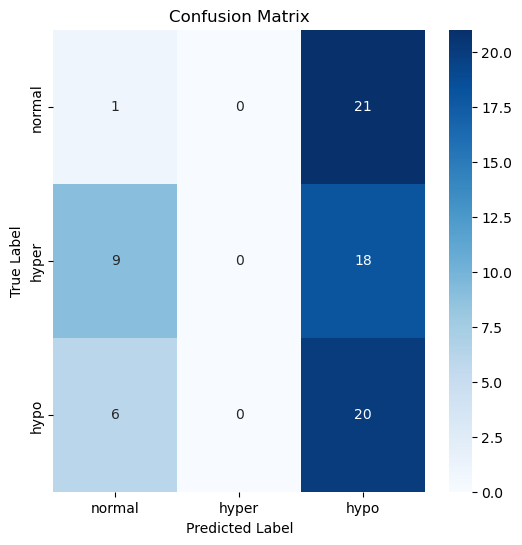

In [5]:
# Compute and Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["normal", "hyper", "hypo"], yticklabels=["normal", "hyper", "hypo"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [6]:
from sklearn.metrics import classification_report
CLASS_NAMES = {'normal': 0, 'hyper': 1, 'hypo': 2}

print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      normal       0.06      0.05      0.05        22
       hyper       0.00      0.00      0.00        27
        hypo       0.34      0.77      0.47        26

    accuracy                           0.28        75
   macro avg       0.13      0.27      0.17        75
weighted avg       0.14      0.28      0.18        75



/home/ryujjoo0810/.conda/envs/my_new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ryujjoo0810/.conda/envs/my_new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ryujjoo0810/.conda/envs/my_new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [7]:
save_path = "video_classification_model.pth"  # Choose a filename
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to video_classification_model.pth


In [9]:

# Convert data to Pandas DataFrame
df = pd.DataFrame({
    "true_label": all_labels,
    "predicted_label": all_preds
})

# Add probability columns for each class
num_classes = all_probs[0].shape[0]
for i in range(num_classes):
    df[f"prob_class_{i}"] = [prob[i] for prob in all_probs]

# Save as CSV
csv_filename = "predictions.csv"
df.to_csv(csv_filename, index=False)

print(f"Predictions saved to {csv_filename}")

Predictions saved to predictions.csv
